In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
import tadasets
from presentation.result import RipserResult


In [2]:
def coborder_matrix(lv, le):
    """
    Create the coborder matrix for the list of
    vertices lv in the basis given by the list of edges le.
    
    Yes it's quadratic (len(lv) * len(le)) but who cares now.
    
    T : can be compared for equality
    lv: list of T
    le: list of sequence(T)
    """
    columns = len(lv)
    rows = len(le)
    M = np.zeros((rows, columns))
    for c, vertex in enumerate(lv):
        for r, edge in enumerate(le):
            if vertex in edge:
                start, end = edge[0], edge[1]
                M[r,c] = -1 if vertex == start else 1
    return M

import enum
class Operator(enum.Enum):
    BORDER = 0
    CO_BORDER = 1

def from_distance(D, operator=Operator.BORDER, threshold=np.infty):
    """Returns the operator matrix associated to the threshold filtration.
    
    Given a distance matrix between vertices we can compute
    the (co)border operator matrix by looking at the distances
    under threshold to create edges and then create the border
    operator matrix. The co-border matrix is just the transposition
    so the computation is the same.
    """
    # edges[r,c] == True if there is an edge from r to c
    # that fits the threshold distance
    under_threshold = (D <= threshold) & (D > 0) # do we need to always have an edge over a vertex itself?
    edges = under_threshold.astype(int)
    # there is an edge between r and c when edges[r,c] == 1
    # but we need to put the correct sign in the (co)border
    # matrix as it is 1 IFF r < c and -1 otherwise
    ones = np.triu(edges)
    oriented_edges = ones - ones.T
    # now we have edges with orientation and we can compute
    # our border matrix
    # there are n vertices to take care of and m edges
    (vertices_num, _) = D.shape
    basis_dimension = vertices_num * (vertices_num + 1)
    matrix = np.zeros((basis_dimension, basis_dimension), dtype=int)
    iterator = np.nditer(oriented_edges, flags=['multi_index'])
    edges_num = vertices_num *(vertices_num -1)
    while not iterator.finished:
        (start, end) = iterator.multi_index
        #if start == end: # there cannot be an edge on the same vertex
        #    iterator.iternext()
        #    continue
        if iterator[0] == 1:
            # there is an edge from start to end
            column = vertices_num * (start + 1) + end
            matrix[start, column] = 1
            matrix[end, column] = -1
        iterator.iternext()
    # we also have put in the basis edges such as (i,i)
    # which should not be there
    # fortunately this is an easy list of columne/rows to drop
    drop = [vertices_num * (i + 1) + i for i in range(vertices_num)]
    wo_columns = np.delete(matrix, drop, axis=1)
    wo_rows = np.delete(wo_columns, drop, axis=0)        
    return wo_rows if operator is Operator.BORDER else wo_rows.T, oriented_edges 

In [3]:
def circular_coordinates(p):
    """
    Returns the same coordinates but modulo Z
    and in the range [0,1)
    """
    fractional = p - np.trunc(p)
    correction = np.floor(fractional)
    return fractional - correction

In [4]:
def drawLineColored(X, C):
    for i in range(X.shape[0]-1):
        plt.plot(X[i:i+2, 0], X[i:i+2, 1], c=C[i, :], lineWidth = 3)

def plotCocycle2D(D, X, cocycle, thresh, width=20, height=10):
    """
    Given a 2D point cloud X, display a cocycle projected
    onto edges under a given threshold "thresh"
    
    D : distance matrix
    X : positions of my vertices
    cocycle :
    thresh :
    width & height: plot dimensions
    """
    N = X.shape[0]
    t = np.linspace(0, 1, 10)
    c = plt.get_cmap('Greys')
    plt.figure(figsize=(width,height))
    C = c(np.array(np.round(np.linspace(0, 255, len(t))), dtype=np.int32))
    C = C[:, 0:3]

    for i in range(N):
        for j in range(N):
            if D[i, j] <= thresh:
                Y = np.zeros((len(t), 2))
                Y[:, 0] = X[i, 0] + t*(X[j, 0] - X[i, 0])
                Y[:, 1] = X[i, 1] + t*(X[j, 1] - X[i, 1])
                drawLineColored(Y, C)
    # Plot cocycle projected to edges under the chosen threshold
    for k in range(cocycle.shape[0]):
        # this edge goes from vertex i to vertex j
        # we associate val to the edge
        [i, j, val] = cocycle[k, :]
        # if the distance between two vertices is less
        # than the threshold then we can plot it
        if D[i, j] <= thresh:
            i, j = min(i, j), max(i, j)
            a = 0.5*(X[i, :] + X[j, :])
            plt.text(a[0], a[1], '%g'%val, color='b', fontsize=18)
            
    # always plot vertex labels otherwise it gets too confusing
    for i in range(N):
        plt.text(X[i, 0], X[i, 1], '%i'%i, color='r', fontsize=18)
    plt.axis('equal')


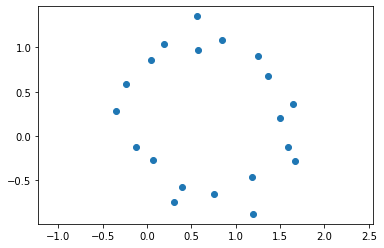

In [5]:
np.random.seed(9)
# x = tadasets.dsphere(n=12, d=1, noise=0.1)

N=20
t = np.linspace(0, 2 * np.pi ,N , endpoint=False)
a = np.transpose([0.5 + np.cos(t), np.sin(t)]) + 0.4 * np.random.random((N,2))
#b = np.transpose([-0.5 + np.cos(t), np.sin(t)]) + 0.4 * np.random.random((N,2))
x = a#np.concatenate([a,b])
plt.scatter(x[:, 0], x[:, 1])
plt.axis('equal')
plt.show()


In [6]:
result = ripser(x, coeff=17, maxdim=2, do_cocycles=True)
diagrams = result['dgms']
cocycles = result['cocycles']
D = result['dperm2all']

In [7]:
def distance(i,j):
    return result['dperm2all'][i,j]

In [8]:
from numpy.linalg import pinv as pseudoinverse
m = np.array([[-1, 1, 0], [-1, 0, 1] , [0, -1, 1]])
p = pseudoinverse(m)
circular_coordinates(p @ (- np.array([1, 0,0])))

array([3.33333333e-01, 6.66666667e-01, 5.48387791e-17])

In [9]:
def compute(D, alpha, r, prime):
    """
    :param D: Distance matrix
    :param alpha: representative co-cycle
    :param r: threshold
    :param prime: prime field coefficients
    """
    def distance(i, j):
        return D[i,j]
    # alpha is a representative co-cycle and we can do the
    # conversion to our fancy thingy
    representative = Representative(alpha)
    alpha_r = representative.project(distance, threshold)

In [17]:
r = RipserResult(x, result)
r.cohomology.H0

AttributeError: 'CoHomology' object has no attribute 'H0'